# Tarea 1 - Taller de Deep Learning

**Johny Kidd: 228175**  

# Imports


In [21]:
# Core Python
import os
import random
import numpy as np
from collections import Counter


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Weights & Biases
import wandb
wandb.login()  # pegás tu API key la primera vez


Usando device: cuda


True

## Seteo de Variables

In [22]:
BATCH_SIZE = 128
NUM_WORKERS = 4

# Carga de Dataset


In [23]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

# Cargamos Imagenette 160px
train_dataset = datasets.Imagenette(
    root="./data", size="160px", split="train", download=False, transform=transform
)
val_dataset = datasets.Imagenette(
    root="./data", size="160px", split="val", download=False, transform=transform
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Clases: {train_dataset.classes}")


Train size: 9469
Val size: 3925
Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


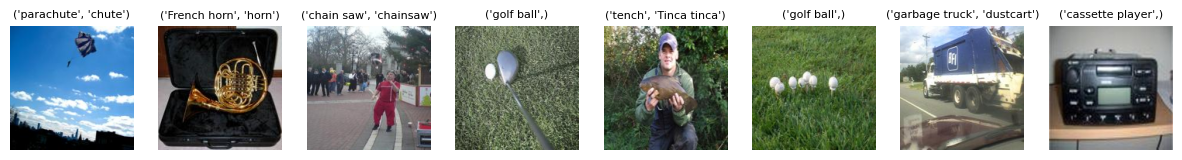

In [25]:
# Mostrar algunos ejemplos de imágenes
def show_samples(dataset, n=8):
    indices = np.random.choice(len(dataset), n, replace=False)  # Selecciona índices aleatorios
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(dataset.classes[label], fontsize=8)
        axes[i].axis("off")
    plt.show()

show_samples(train_dataset)

# Seteo de wandb (testeo)

In [ ]:
import wandb

# Inicializamos wandb
wandb.init(
    project="imagenette",        # Nombre único del proyecto
    name="setup_test",           # Nombre del run (descriptivo)
    tags=["setup", "test"],      # Tags para filtrar después
    config={                     # Configuración base (puedes expandir luego)
        "dataset": "imagenette160",
        "batch_size": 64,
        "lr": 1e-3,
        "epochs": 1,
        "optimizer": "Adam",
        "model": "SetupTest"
    }
)

# Log de prueba
for epoch in range(3):
    wandb.log({
        "epoch": epoch,
        "train_loss": 1.0 / (epoch + 1),
        "val_loss": 1.2 / (epoch + 1),
        "val_acc": 0.3 * (epoch + 1)
    })

wandb.finish()

# Análisis Exploratorio de Datos (EDA)

## Balanceo de Clases

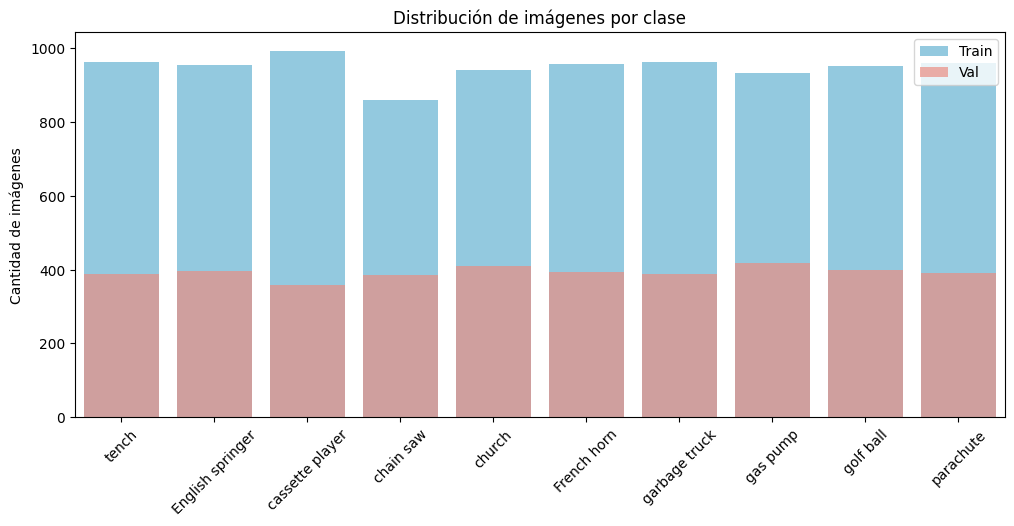

In [26]:
class_names = train_dataset.classes
class_names_simple = [c[0] if isinstance(c, tuple) else c for c in class_names]

train_labels = [label for _, label in train_dataset._samples]
val_labels = [label for _, label in val_dataset._samples]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

train_distribution = [train_counts[i] for i in range(len(class_names))]
val_distribution = [val_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(12,5))
sns.barplot(x=class_names_simple, y=train_distribution, color="skyblue", label="Train")
sns.barplot(x=class_names_simple, y=val_distribution, color="salmon", alpha=0.7, label="Val")
plt.xticks(rotation=45)
plt.title("Distribución de imágenes por clase")
plt.ylabel("Cantidad de imágenes")
plt.legend()
plt.show()


La distribución de imágenes por clase en los conjuntos de entrenamiento y validación del dataset Imagenette es balanceada. Todas las clases presentan cantidades similares de ejemplos, tanto en train como en val, lo que asegura que el modelo no estará sesgado hacia ninguna clase en particular. Por lo tanto, no es necesario aplicar técnicas de balanceo o muestreo adicional para este dataset.

## Tamaño y Aspect Ratio

Ancho: mean=160.0, std=0.0, min=160, max=160
Alto: mean=160.0, std=0.0, min=160, max=160
Aspect ratio: mean=1.00, std=0.00, min=1.00, max=1.00


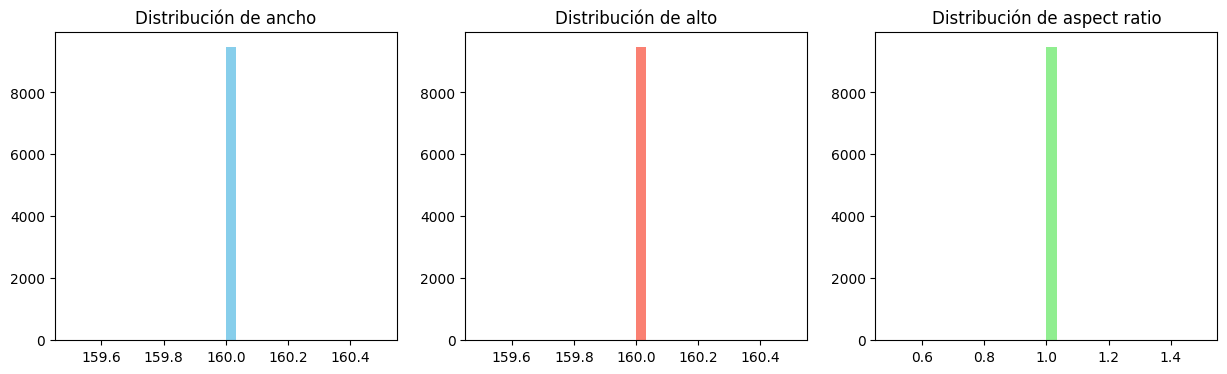

In [27]:

widths, heights, aspect_ratios = [], [], []


for img, _ in train_dataset:
    pil_img = transforms.ToPILImage()(img)
    w, h = pil_img.size  
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)

widths = np.array(widths)
heights = np.array(heights)
aspect_ratios = np.array(aspect_ratios)

print("Ancho: mean={:.1f}, std={:.1f}, min={}, max={}".format(widths.mean(), widths.std(), widths.min(), widths.max()))
print("Alto: mean={:.1f}, std={:.1f}, min={}, max={}".format(heights.mean(), heights.std(), heights.min(), heights.max()))
print("Aspect ratio: mean={:.2f}, std={:.2f}, min={:.2f}, max={:.2f}".format(aspect_ratios.mean(), aspect_ratios.std(), aspect_ratios.min(), aspect_ratios.max()))

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(widths, bins=30, color='skyblue')
plt.title("Distribución de ancho")

plt.subplot(1,3,2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Distribución de alto")

plt.subplot(1,3,3)
plt.hist(aspect_ratios, bins=30, color='lightgreen')
plt.title("Distribución de aspect ratio")

plt.show()


Todas las imágenes del dataset han sido redimensionadas a un tamaño uniforme de 160x160 píxeles, con un aspect ratio de 1.0. Esto garantiza que el modelo reciba entradas homogéneas, facilitando el procesamiento por lotes y evitando distorsiones o sesgos relacionados con diferentes tamaños o proporciones. Esta uniformidad es fundamental para asegurar un entrenamiento estable y eficiente, y permite comparar resultados de manera justa entre diferentes experimentos y arquitecturas.

## Media y Desviación Estándar de canales de color

Media por canal RGB: tensor([0.4625, 0.4580, 0.4298])
Desviación estándar por canal RGB: tensor([0.2748, 0.2690, 0.2856])


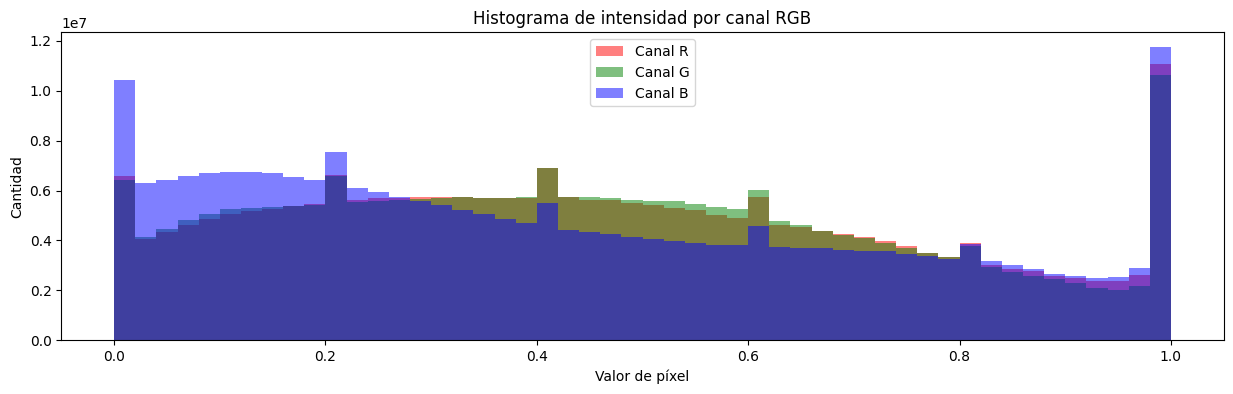

In [28]:
means = []
stds = []

#iteramos por batchss para no sarturar memoria
loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)

for imgs, _ in loader:
    means.append(imgs.mean(dim=[0,2,3]))  # mean por canal
    stds.append(imgs.std(dim=[0,2,3]))    # std por canal

mean = torch.stack(means).mean(dim=0)
std = torch.stack(stds).mean(dim=0)

print("Media por canal RGB:", mean)
print("Desviación estándar por canal RGB:", std)

# Histograma de intensidad por canal
all_pixels = []
for imgs, _ in loader:
    all_pixels.append(imgs)

all_pixels = torch.cat(all_pixels, dim=0)  # shape [N, C, H, W]

plt.figure(figsize=(15,4))
colors = ['r','g','b']
for i, color in enumerate(colors):
    plt.hist(all_pixels[:,i,:,:].numpy().flatten(), bins=50, color=color, alpha=0.5, label=f'Canal {color.upper()}')
plt.title("Histograma de intensidad por canal RGB")
plt.xlabel("Valor de píxel")
plt.ylabel("Cantidad")
plt.legend()
plt.show()


## Calidads de las imágenes

Iniciando el análisis de calidad detallado en 9469 imágenes...
--------------------------------------------------
Total de imágenes analizadas: 9469

--- Desglose de Problemas (Superpuestos) ---
1. Borrosidad (<10.0):      2 (0.02%)
2. Muy Oscuras (<30.0):    45 (0.48%)
3. Muy Brillantes (>220.0): 60 (0.63%)
4. Bajo Contraste (<15.0): 59 (0.62%)

--- Resumen General ---
Imágenes con MÚLTIPLES problemas (>=2): 2 (0.02%)
Imágenes problemáticas TOTALES (>=1):    164 (1.73%)
--------------------------------------------------


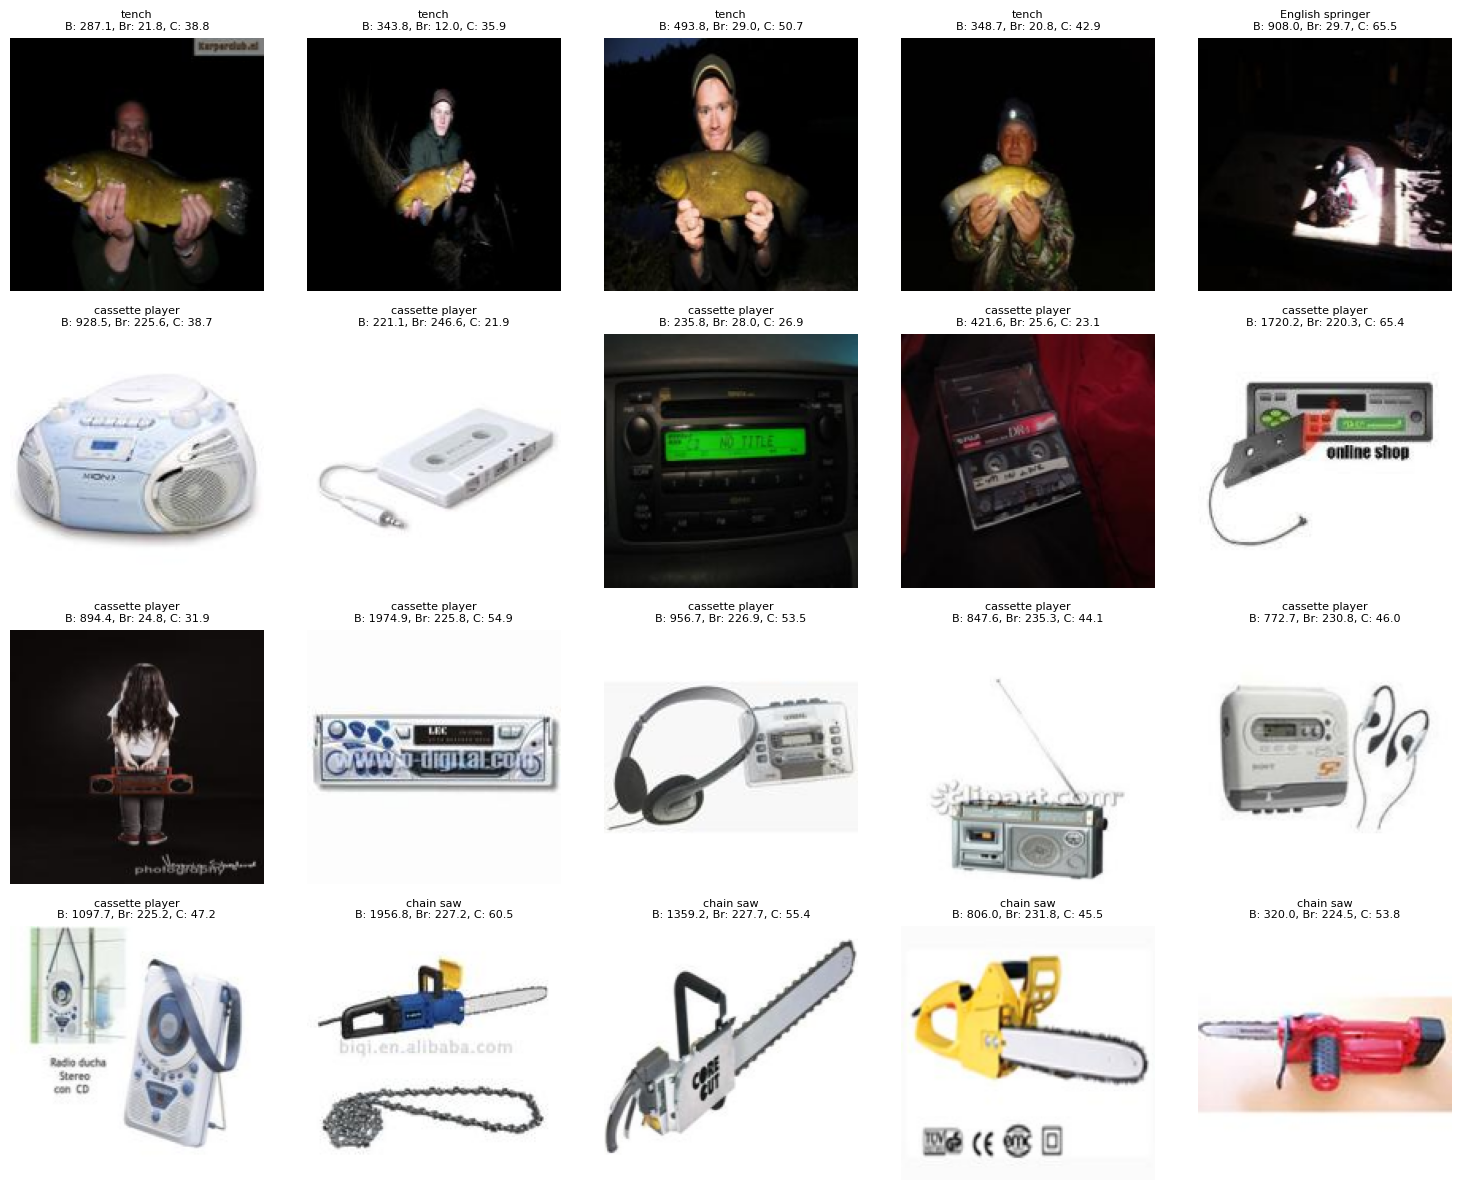

In [29]:
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# --- Definición de Funciones de Puntuación ---
def blur_score(img):
    """Calcula el score de borrosidad usando la Varianza del Laplaciano."""
    img_gray = np.array(img.convert('L'))
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

def brightness_score(img):
    """Calcula el brillo promedio (media del píxel) en escala de grises."""
    img_gray = np.array(img.convert('L'))
    return img_gray.mean()

def contrast_score(img):
    """Calcula el contraste (desviación estándar) en escala de grises."""
    img_gray = np.array(img.convert('L'))
    return img_gray.std()

# --- Umbrales (los que definiste) ---
blur_threshold = 10      # <10: borrosa
dark_threshold = 30      # <30: muy oscura
bright_threshold = 220   # >220: muy brillante
contrast_threshold = 15  # <15: poco contraste

# --- Lógica de Conteo Detallado ---
total_images = len(train_dataset)

# Contadores para cada tipo de problema (pueden superponerse)
count_blur = 0
count_dark = 0
count_bright = 0
count_low_contrast = 0
count_multiple_problems = 0
total_problem_count = 0

problem_images_examples = [] # Para guardar un máximo de 20 ejemplos para plotear

print(f"Iniciando el análisis de calidad detallado en {total_images} imágenes...")

# Iterar sobre todo el dataset de entrenamiento
for i, (img, label) in enumerate(train_dataset):
    # Asegurarse de tener una imagen PIL para los cálculos
    pil_img = img if isinstance(img, Image.Image) else transforms.ToPILImage()(img)
    
    blur = blur_score(pil_img)
    bright = brightness_score(pil_img)
    contrast = contrast_score(pil_img)
    
    current_problems = 0
    is_problematic = False
    
    # 1. Borrosidad
    if blur < blur_threshold:
        count_blur += 1
        current_problems += 1
        is_problematic = True

    # 2. Brillo (Oscuro)
    if bright < dark_threshold:
        count_dark += 1
        current_problems += 1
        is_problematic = True

    # 3. Brillo (Brillante)
    if bright > bright_threshold:
        count_bright += 1
        current_problems += 1
        is_problematic = True

    # 4. Contraste (Bajo)
    if contrast < contrast_threshold:
        count_low_contrast += 1
        current_problems += 1
        is_problematic = True

    # Contar si tiene MÚLTIPLES problemas (2 o más)
    if current_problems >= 2:
        count_multiple_problems += 1
        
    # Contar el total de imágenes con AL MENOS un problema
    if is_problematic:
        total_problem_count += 1
        # Guardar ejemplos solo si no hemos alcanzado el límite de 20
        if len(problem_images_examples) < 20:
            problem_images_examples.append((pil_img, label, blur, bright, contrast))


# --- Resultados del Conteo ---
def get_percentage(count, total):
    return (count / total) * 100

print("-" * 50)
print(f"Total de imágenes analizadas: {total_images}")
print("\n--- Desglose de Problemas (Superpuestos) ---")
print(f"1. Borrosidad (<{blur_threshold:.1f}):      {count_blur} ({get_percentage(count_blur, total_images):.2f}%)")
print(f"2. Muy Oscuras (<{dark_threshold:.1f}):    {count_dark} ({get_percentage(count_dark, total_images):.2f}%)")
print(f"3. Muy Brillantes (>{bright_threshold:.1f}): {count_bright} ({get_percentage(count_bright, total_images):.2f}%)")
print(f"4. Bajo Contraste (<{contrast_threshold:.1f}): {count_low_contrast} ({get_percentage(count_low_contrast, total_images):.2f}%)")

print("\n--- Resumen General ---")
print(f"Imágenes con MÚLTIPLES problemas (>=2): {count_multiple_problems} ({get_percentage(count_multiple_problems, total_images):.2f}%)")
print(f"Imágenes problemáticas TOTALES (>=1):    {total_problem_count} ({get_percentage(total_problem_count, total_images):.2f}%)")
print("-" * 50)

# --- Visualización de Ejemplos ---
# (El código de visualización de ejemplos sigue siendo el mismo)
if problem_images_examples:
    num_plots = len(problem_images_examples)
    rows = (num_plots + 4) // 5  # Calcular filas necesarias para 5 columnas
    
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))
    
    # Manejar el caso de una sola fila de plots
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) and axes.ndim > 1 else (axes.flatten() if isinstance(axes, np.ndarray) else [axes])
    
    for ax, (img, label, blur, bright, contrast) in zip(axes_flat, problem_images_examples):
        # Asumiendo que 'class_names_simple' está definido. Si no, usa f"Clase {label}"
        try:
            class_name = class_names_simple[label]
        except (NameError, TypeError):
            class_name = f"Clase {label}"

        ax.imshow(img)
        ax.set_title(f"{class_name}\nB: {blur:.1f}, Br: {bright:.1f}, C: {contrast:.1f}", fontsize=8)
        ax.axis('off')

    # Ocultar ejes sobrantes
    for i in range(num_plots, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron ejemplos problemáticos para plotear con los umbrales definidos.")

## Brillo, Contraste y Saturación

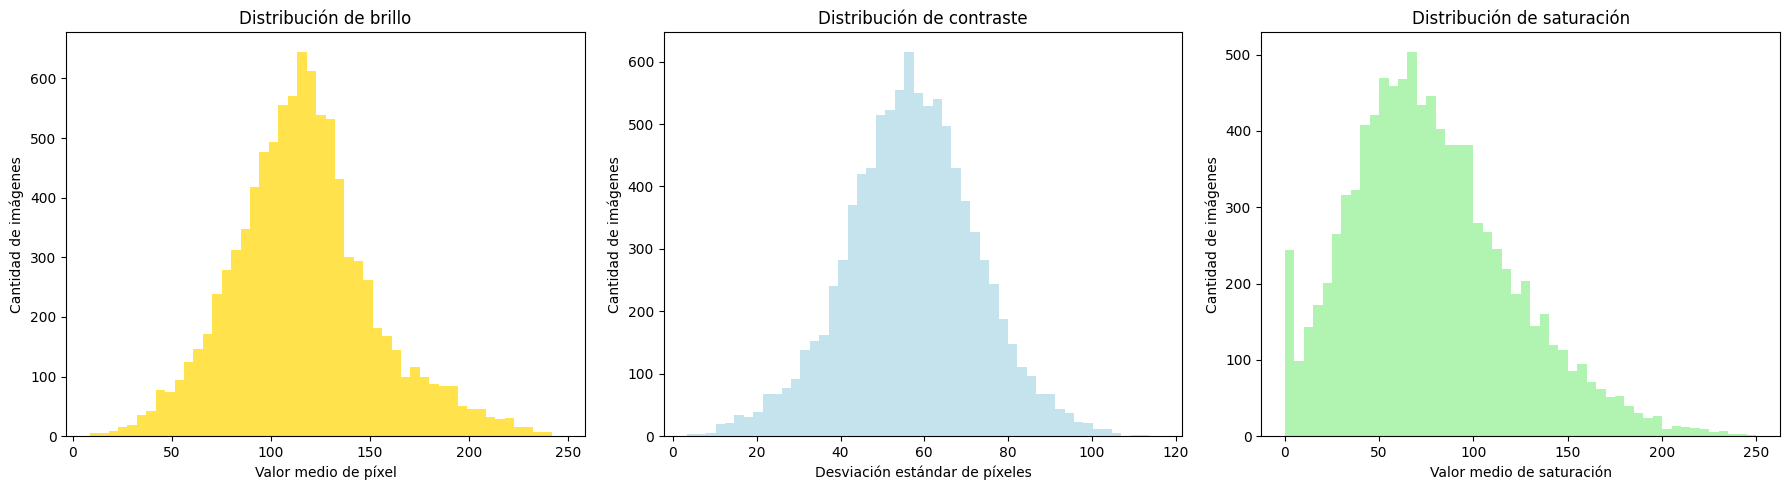

In [10]:
import colorsys

brightness_list = []
contrast_list = []
saturation_list = []

for img, _ in train_dataset:
    # Convertir a PIL si no lo es
    pil_img = img if isinstance(img, Image.Image) else transforms.ToPILImage()(img)
    
    # Convertir a array
    img_arr = np.array(pil_img)
    
    # Brillo y contraste (en escala de grises)
    gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
    brightness_list.append(gray.mean())
    contrast_list.append(gray.std())
    
    # Saturación promedio
    hsv = cv2.cvtColor(img_arr, cv2.COLOR_RGB2HSV)
    saturation_list.append(hsv[:,:,1].mean())

# Convertir a numpy
brightness_list = np.array(brightness_list)
contrast_list = np.array(contrast_list)
saturation_list = np.array(saturation_list)

# Histogramas
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(brightness_list, bins=50, color='gold', alpha=0.7)
plt.title("Distribución de brillo")
plt.xlabel("Valor medio de píxel")
plt.ylabel("Cantidad de imágenes")

plt.subplot(1,3,2)
plt.hist(contrast_list, bins=50, color='lightblue', alpha=0.7)
plt.title("Distribución de contraste")
plt.xlabel("Desviación estándar de píxeles")
plt.ylabel("Cantidad de imágenes")

plt.subplot(1,3,3)
plt.hist(saturation_list, bins=50, color='lightgreen', alpha=0.7)
plt.title("Distribución de saturación")
plt.xlabel("Valor medio de saturación")
plt.ylabel("Cantidad de imágenes")

plt.tight_layout()
plt.show()


## Análisis del espectro de frecuencia (FFT)

In [11]:
import numpy as np
import cv2
from PIL import Image

def calcular_espectro_fft(img):
    """
    Calcula el espectro de magnitud de Fourier centrado de una imagen RGB/PIL/torch.Tensor.
    """
    # Convertir a PIL si es tensor
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0)  # C,H,W -> H,W,C
        img = (img * 255).astype(np.uint8)    # De [0,1] a [0,255]
    elif isinstance(img, Image.Image):
        img = np.array(img)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # FFT 2D y centrar frecuencia baja
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    
    # Magnitud logarítmica
    magnitude = 20 * np.log(np.abs(fshift) + 1e-8)  # epsilon para evitar log(0)
    return magnitude


In [15]:
from tqdm.notebook import tqdm 
import random

num_samples = min(9000, len(train_dataset))  # limitar muestra por velocidad
indices_muestra = random.sample(range(len(train_dataset)), num_samples)

# Inicializar con la primera imagen
espectro_acumulado = np.zeros_like(calcular_espectro_fft(train_dataset[0][0]))

print(f"Calculando espectro promedio sobre {num_samples} imágenes...")
for i in tqdm(indices_muestra):
    img, _ = train_dataset[i]
    espectro = calcular_espectro_fft(img)
    if espectro.shape == espectro_acumulado.shape:
        espectro_acumulado += espectro

espectro_promedio = espectro_acumulado / num_samples


Calculando espectro promedio sobre 9000 imágenes...


  0%|          | 0/9000 [00:00<?, ?it/s]

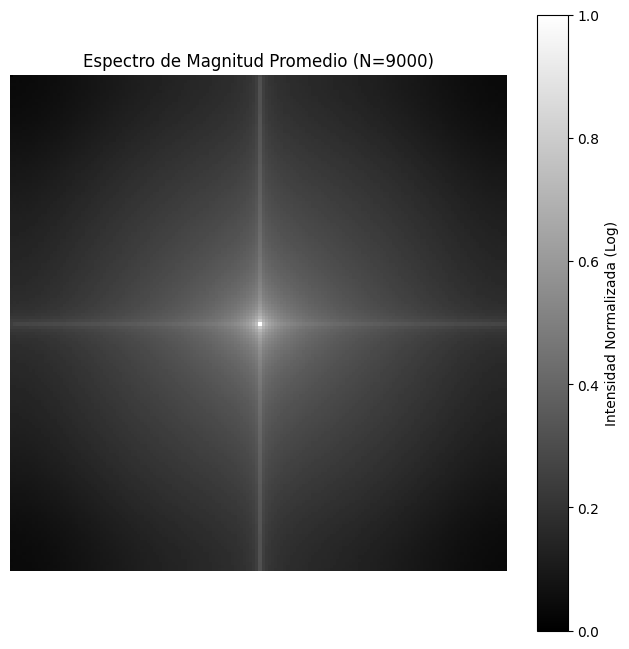

In [13]:
import matplotlib.pyplot as plt

espectro_norm = (espectro_promedio - np.min(espectro_promedio)) / (np.max(espectro_promedio) - np.min(espectro_promedio))

plt.figure(figsize=(8, 8))
plt.imshow(espectro_norm, cmap='gray')
plt.title(f'Espectro de Magnitud Promedio (N={num_samples})')
plt.colorbar(label='Intensidad Normalizada (Log)')
plt.axis('off')
plt.show()


## Estimación de ruido local

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tqdm.notebook import tqdm
# Asumo que 'transforms' viene de PyTorch si usas un dataset estándar
try:
    import torchvision.transforms as transforms
except ImportError:
    # Definir un dummy si no se usa PyTorch (solo si no se requiere la conversión)
    class DummyTransform:
        def __call__(self, img):
            return img
    transforms = type('transforms', (object,), {'ToPILImage': lambda: DummyTransform()})()

# Celda 1: Cálculo de Ruido y Almacenamiento de Índices

# Parámetros para la estimación:
PATCH_SIZE = 10 
num_muestras_ruido = min(9000, len(train_dataset)) 

def estimar_ruido_local(image_rgb):
    """Estima el ruido como la desviación estándar local en la imagen."""
    
    # Manejo del formato de la imagen para cv2
    if image_rgb.dtype != np.uint8:
        # Asume que si no es uint8, está normalizada a 0-1, la escalamos.
        # Ajusta esta línea si sabes que tus arrays NumPy tienen otro rango (ej. 0-255 en float)
        image_rgb = (image_rgb * 255).astype(np.uint8) 
        
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    H, W = gray_image.shape
    
    if H < PATCH_SIZE or W < PATCH_SIZE:
         return 0 # Si es muy pequeña, la omitimos o asignamos un valor bajo
         
    varianzas_locales = []
    
    # Tomar 10 parches aleatorios en la imagen para estimar la variación local
    for _ in range(10): 
        x = np.random.randint(0, W - PATCH_SIZE)
        y = np.random.randint(0, H - PATCH_SIZE)
        
        patch = gray_image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
        varianzas_locales.append(np.std(patch))
        
    return np.mean(varianzas_locales)

# Almacenamos tuplas (índice, ruido_estimado)
ruidos_estimados_con_indice = []
print(f"Estimando ruido local en {num_muestras_ruido} imágenes...")

for i in tqdm(range(num_muestras_ruido)):
    # Asume que train_dataset[i] devuelve (imagen, etiqueta)
    img, _ = train_dataset[i] 
    
    # Manejo de formatos: si es un objeto Tensor/PIL, lo convertimos a NumPy array
    if not isinstance(img, np.ndarray):
        try:
            # Si es un Tensor de PyTorch, lo convertimos a NumPy (CHW -> HWC)
            # Nota: Esto asume el orden de canales de PyTorch
            img = np.array(transforms.ToPILImage()(img))
        except:
             # Si falla la conversión a PIL/NumPy (caso extremo), usamos el array directamente si es posible
             if hasattr(img, 'numpy'):
                 img = img.numpy().transpose((1, 2, 0))
             else:
                 img = np.array(img)
    
    ruido_est = estimar_ruido_local(img)
    ruidos_estimados_con_indice.append((i, ruido_est))

# Convertir a array NumPy para cálculos estadísticos
ruidos_array = np.array([r[1] for r in ruidos_estimados_con_indice])
media_ruido = np.mean(ruidos_array)
std_ruido = np.std(ruidos_array)

print("\n--- Resultados Estadísticos ---")
print(f"Media ($\mu$): {media_ruido:.2f}, Desviación Estándar ($\sigma$): {std_ruido:.2f}")

# --- Identificación de Outliers (Para la visualización) ---
umbral_alto = media_ruido + 2 * std_ruido
indices_ruido_alto = [
    i for i, ruido in ruidos_estimados_con_indice if ruido > umbral_alto
]

print(f"Umbral para ruido alto ($\mu + 2\sigma$): {umbral_alto:.2f}")
print(f"Se encontraron {len(indices_ruido_alto)} imágenes con $\sigma_n$ superior a este umbral.")

Estimando ruido local en 9000 imágenes...


  0%|          | 0/9000 [00:00<?, ?it/s]


--- Resultados Estadísticos ---
Media ($\mu$): 23.39, Desviación Estándar ($\sigma$): 9.47
Umbral para ruido alto ($\mu + 2\sigma$): 42.32
Se encontraron 272 imágenes con $\sigma_n$ superior a este umbral.


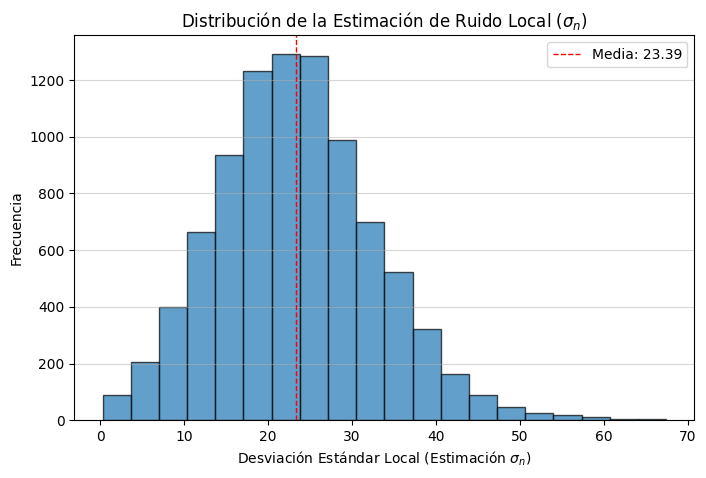

El alto valor de la media (23.47) indica una alta granularidad/textura en el dataset.


In [17]:
# Celda 2: Visualización (Tu Histograma)

plt.figure(figsize=(8, 5))
plt.hist(ruidos_array, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(media_ruido, color='red', linestyle='dashed', linewidth=1, label=f'Media: {media_ruido:.2f}')
plt.title('Distribución de la Estimación de Ruido Local ($\sigma_n$)')
plt.xlabel('Desviación Estándar Local (Estimación $\sigma_n$)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

print("El alto valor de la media (23.47) indica una alta granularidad/textura en el dataset.")

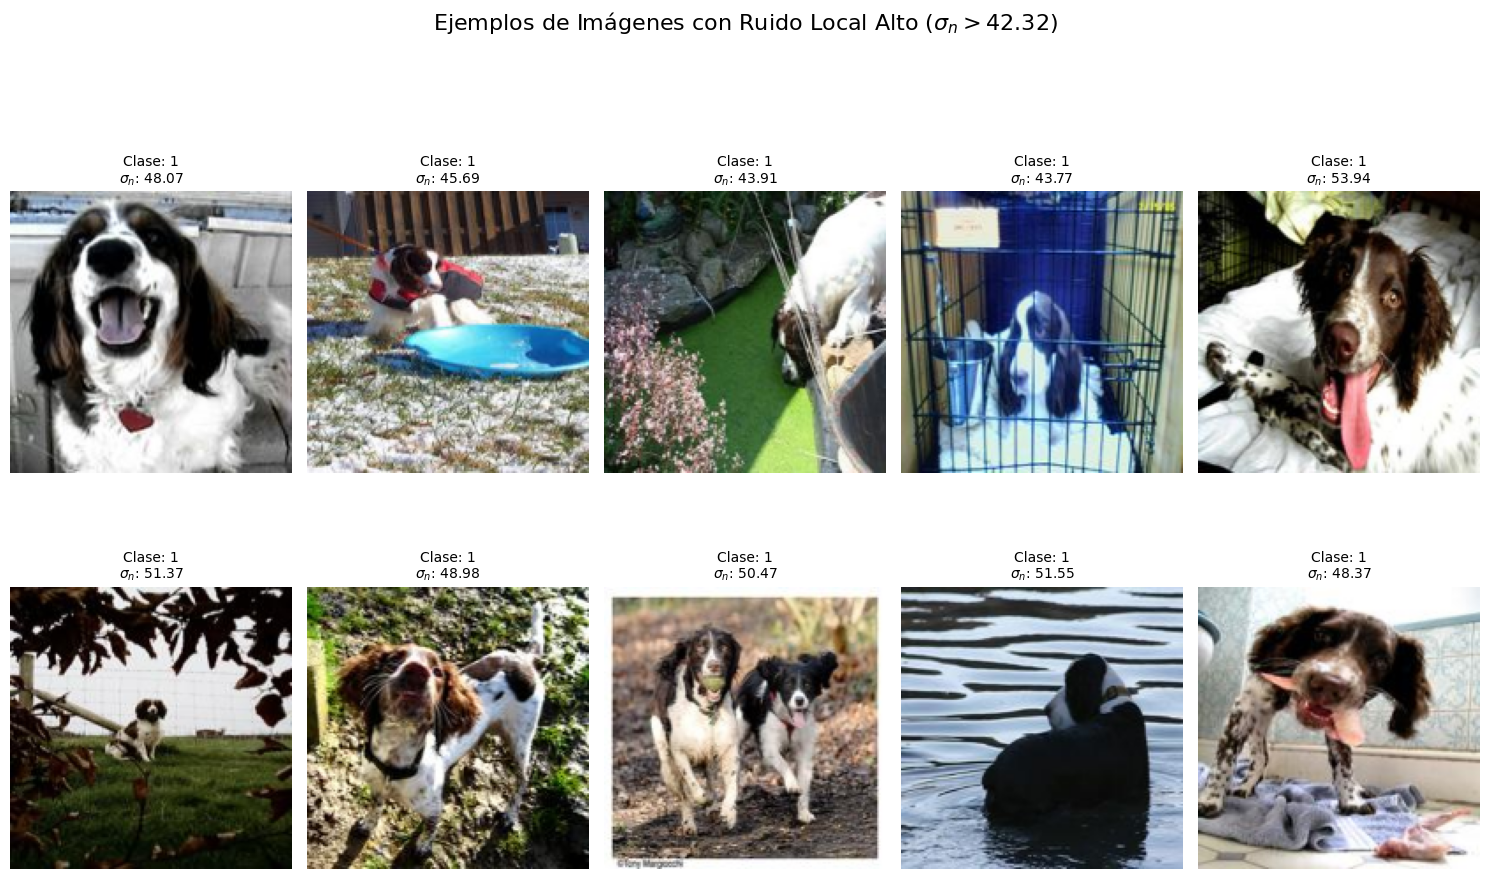

In [20]:
# Celda 3: Visualización de Ejemplos de Ruido Alto (Outliers)

num_a_mostrar = min(10, len(indices_ruido_alto))
indices_a_mostrar = indices_ruido_alto[:num_a_mostrar]

if num_a_mostrar > 0:
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Ejemplos de Imágenes con Ruido Local Alto ($\sigma_n > {umbral_alto:.2f}$)", fontsize=16)

    for i, idx_original in enumerate(indices_a_mostrar):
        img, label_idx = train_dataset[idx_original]
        
        # Volvemos a convertir a NumPy si es necesario
        if not isinstance(img, np.ndarray):
            try:
                img = np.array(transforms.ToPILImage()(img))
            except:
                 if hasattr(img, 'numpy'):
                     img = img.numpy().transpose((1, 2, 0))
                 else:
                     img = np.array(img)

        # Buscar el valor de ruido específico
        ruido_especifico = [r[1] for r in ruidos_estimados_con_indice if r[0] == idx_original][0]
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img) 
        plt.title(f"Clase: {label_idx}\n$\\sigma_n$: {ruido_especifico:.2f}", fontsize=10)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No hay suficientes imágenes con ruido extremadamente alto (o el umbral es muy estricto) para mostrar.")

# Principales Insights del EDA